In [32]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, SimpleRNN, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer as TFTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences as TFpad_sequences
from nltk.corpus import stopwords
from keras.callbacks import EarlyStopping
# from googletrans import Translator
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
import pandas as pd
import os
import nltk
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.optimizers import Adam
import emoji
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
import math
from typing import Union
from tensorflow.keras.models import Model

nltk.download('punkt')
nltk.download('wordnet')

# Additional Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing class

In [33]:
# truncation of sequences
class Preprocessing:
    
    def __init__(self):
        self.max_vocab_size = None
        self.max_sequence_length = None
        self.tokenizer = Tokenizer()
        self.label_encoder = LabelEncoder()
        
        
    def calculate_max_lengths(self, texts):
        self.max_vocab_size = len(set(' '.join(texts).split())) + 1
        self.max_sequence_length = max(len(text.split()) for text in texts)
        
        
    def tokenize(self, texts):
        # vocalbolary declaration
        self.tokenizer.fit_on_texts(texts)

    def encode(self, texts):
        # tokenization and indexing
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_sequence_length, padding=self.padding)
        return padded_sequences
         
    def remove_dublicate_emoji_(self,input_str):

        text = ''.join([c for c in input_str if not emoji.emoji_count(c) > 0])
        emojis = [c for c in input_str if emoji.emoji_count(c) > 0]

        unique_emojis = set(emojis)

        result_str = text + ''.join(unique_emojis)

        return result_str
    
    def remove_dublicate_emoji(self,text):
        
        v_remove_dublicate_emoji = np.vectorize(self.remove_dublicate_emoji_)
        return v_remove_dublicate_emoji(text)
        

    def labels_decoding(self,encoded_labels):
         return label_encoder.inverse_transform(self.label_encoder)
    
    


    def remove_stopwords(self, text):

        text = text.tolist()

        stop_words = set(stopwords.words('arabic'))

        filtered_texts = [' '.join([word for word in word_tokenize(sentence) if word not in stop_words]) for sentence in text]

        return filtered_texts

    
    def labels_encoding(self,labels, f = 0):

            if (f == 1):
                return self.label_encoder.fit_transform(labels)
            else:
                return self.label_encoder.transform(labels)


    def preprocess_text(self, text):

#         filtered_text = self.remove_stopwords(text)
        unique_emojis = self.remove_dublicate_emoji(text)

        return unique_emojis
   


   
    
    def train_preprocess(self, features,labels, padding = 'post'):

        self.padding = padding
        
        # stop words and emojis
        cleaned_text =self.preprocess_text(features)
        
        # encode sequences 
        self.calculate_max_lengths(cleaned_text)
        self.tokenize(cleaned_text)
        
        new_features = self.encode(cleaned_text)
        
        # encode labels
        labels_encoded = self.labels_encoding(labels, 1)
    
        return new_features, labels_encoded
    

    def test_preprocess(self, features, labels = None):

        # stop words and emojis
        cleaned_text =self.preprocess_text(features)

        # encode sequences
        new_features = self.encode(cleaned_text)
        
        if labels is None:
            return new_features
        
        # encode label
        labels_encoded = self.labels_encoding(labels)
        
        return new_features, labels_encoded

## Read data

In [34]:

df = pd.read_excel('/kaggle/input/review-data/train.xlsx')

df_pred = pd.read_csv('/kaggle/input/review-data/test _no_label.csv')
df['rating'].value_counts()

rating
 1    19189
-1    11340
 0     1507
Name: count, dtype: int64

## Extraxt features & labels

In [35]:

# Training & Test
d_x = np.array(df['review_description'])
d_y = np.array(df['rating'])

X = d_x
y = d_y


y_test = X_test = None

# Prediction

X_predict_ = np.array(df_pred['review_description'])
idx = np.array(df_pred['ID'])

## Splitting data into (Train, Validation, and Test)

Training Set (X_train, y_train): **90%**

Validation Set (X_valid, y_valid): **5%**

Test Set (X_test, y_test): **5%**

In [36]:
vt = 0.05
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=vt*2, random_state=42)
X_test_, X_valid_, y_test_, y_valid_ = train_test_split(X_test_, y_test_, test_size= 0.5, random_state=38)


print("\nX_train: ", X_train_.shape)

print("X_valid: ", X_valid_.shape)

print("X_test: ", X_test_.shape)




X_train:  (28832,)
X_valid:  (1602,)
X_test:  (1602,)


## Check distribution

In [37]:

tmp_df = pd.DataFrame({'data': X_train_, 'rating': y_train_})
print(tmp_df['rating'].value_counts())


rating
 1    17281
-1    10193
 0     1358
Name: count, dtype: int64


## Oversampling
applied on the minority class (just for **training** set)

In [38]:


tmp_df = pd.DataFrame({'data': X_train_, 'rating': y_train_})

print("Before over sampling:")
print(tmp_df['rating'].value_counts())


# Minority class
minority_class = tmp_df[tmp_df['rating'] == 0]

# Oversample 
desired_count = 14000 
oversampled_minority_class = minority_class.sample(n=desired_count, replace=True, random_state=42)

# Concatenate the new samples with the minority class
df_resampled = pd.concat([tmp_df, oversampled_minority_class], ignore_index=True)


# -1

minority_class = tmp_df[tmp_df['rating'] == -1]

# Oversample 
desired_count = 6000 
oversampled_minority_class = minority_class.sample(n=desired_count, replace=True, random_state=42)

# Concatenate the new samples with the minority class
df_resampled = pd.concat([df_resampled, oversampled_minority_class], ignore_index=True)


# Shuffle the data
df_resampled = shuffle(df_resampled, random_state=42).reset_index(drop=True)

# Check Distribution
print('\nAfter:')
print(df_resampled['rating'].value_counts())

# Extract X_train & y_train
X_train_oversampled = np.array(df_resampled['data'])
y_train_oversampled = np.array(df_resampled['rating'])
y_train_oversampled.shape

Before over sampling:
rating
 1    17281
-1    10193
 0     1358
Name: count, dtype: int64

After:
rating
 1    17281
-1    16193
 0    15358
Name: count, dtype: int64


(48832,)

## Apply preprocessing separately

In [39]:
pre = Preprocessing()

X_train, y_train = pre.train_preprocess(X_train_, y_train_)
X_test = pre.test_preprocess(X_test_)
X_valid, y_valid = pre.test_preprocess(X_valid_, y_valid_)
X_predict = pre.test_preprocess(X_predict_)
y_test = y_test_


## Embedding layer hyperparameters

In [40]:
vocab_size = len(pre.tokenizer.word_index) + 1
embedding_dim = 100
max_length = len(X_train[0])
X_train.shape
# print(vocab_size)

(28832, 374)

## LSTM model
(Architecture)

In [41]:

class LSTModel:
    def __init__ (self):
        self.model = Sequential()
        
    # Build model arcitecture    
    def build(self,vocab_size, embedding_dim, max_length, lstm_units=16):
        
        # Embedding layer
        self.model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
        
        # Lstm Layer
        self.model.add(Bidirectional(LSTM(units=lstm_units)))
        
         # Output Layer
        self.model.add(Dense(units=3, activation='softmax'))
        
        # Configure model
        optimizer = Adam(learning_rate=0.0001)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        return self.model
    
    # Fit the model and return the history of learning
    def train(self, X_train, y_train, X_valid, y_valid, epochs=20, batch_size=100, early_stopping =True):
        if(early_stopping):
            early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True,
                            validation_data=(X_valid,y_valid), callbacks= early_stopping)
        return self.history
   
   # Generate predicted labels
    def predict(self, X_test): 
        
        # predicte Probabilities of the 3 classes       
        predicted_labels = self.model.predict(X_test)
        
        # Extracting the index of the most probable class and adjusting to a convention of [-1, 0, 1].
        predicted_labels = np.argmax(predicted_labels, axis=1) - 1
        return predicted_labels



In [42]:
lstm_model = LSTModel()
lstm_model.build(vocab_size, embedding_dim, max_length)
lstm_history = lstm_model.train(X_train, y_train, X_valid, y_valid,epochs = 5, early_stopping=False)



Epoch 1/5
289/289 [==============================] - 41s 129ms/step - loss: 0.9342 - accuracy: 0.5452 - val_loss: 0.7946 - val_accuracy: 0.5930
Epoch 2/5
289/289 [==============================] - 20s 70ms/step - loss: 0.7372 - accuracy: 0.6478 - val_loss: 0.6839 - val_accuracy: 0.7266
Epoch 3/5
289/289 [==============================] - 14s 49ms/step - loss: 0.6052 - accuracy: 0.7861 - val_loss: 0.5611 - val_accuracy: 0.7990
Epoch 4/5
289/289 [==============================] - 12s 42ms/step - loss: 0.4953 - accuracy: 0.8366 - val_loss: 0.5141 - val_accuracy: 0.8096
Epoch 5/5
289/289 [==============================] - 12s 41ms/step - loss: 0.4360 - accuracy: 0.8579 - val_loss: 0.4867 - val_accuracy: 0.8296


(Training)

(Analysis)

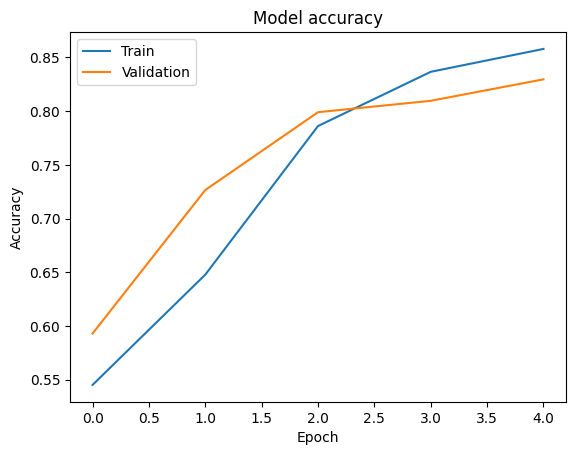

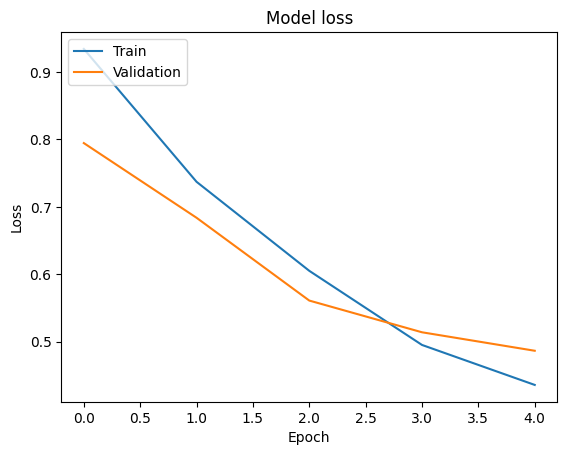

In [43]:

# Plot training & validation accuracy values
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Transformer Model
(Architecture)

In [52]:

class Transformer:
    
    def __init__(self):
        self.model = None
        self.history = None
        
    
    def build(self, input_dim,  embedding_dim, max_length ,num_heads= 16, num_classes = 3, dropout_rate = 0.4):
        inputs = Input(shape=(max_length,))

        # Token embedding layer
        embedding = Embedding(input_dim, embedding_dim, input_length=max_length)(inputs)

        # Positional encoding
        pos_encoding = self.positional_encoding(max_length, embedding_dim)
        embedded = embedding + pos_encoding

        # Multi-head self-attention
        attention = MultiHeadAttention(num_heads=num_heads, key_dim=num_heads)(embedded, embedded, embedded)
        attention = Dropout(dropout_rate)(attention)
        attention = LayerNormalization(epsilon=1e-6)(embedded + attention)

        # Feed-forward layer
        feed_forward = Dense(embedding_dim, activation='relu')(attention)
        feed_forward = Dropout(dropout_rate)(feed_forward)
        x = LayerNormalization(epsilon=1e-6)(attention + feed_forward)

        # Global average pooling
        x = GlobalAveragePooling1D()(x)

        # Output layer
        outputs = Dense(num_classes, activation='softmax')(x)

        # Model
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        # Configure model
        optimizer = Adam(learning_rate=0.0001)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        


    
    # Fit the model and return the history of learning
    def train(self, X_train, y_train, X_valid, y_valid, epochs=20, batch_size=100, early_stopping =True):
        if(early_stopping):
            early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
            
        self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_data=(X_valid,y_valid), callbacks= early_stopping)
        return self.history
    
    
    # Generate predicted labels
    def predict(self, X_test): 
        
        # predicte Probabilities of the 3 classes       
        predicted_labels = self.model.predict(X_test)
        
        # Extracting the index of the most probable class and adjusting to a convention of [-1, 0, 1].
        predicted_labels = np.argmax(predicted_labels, axis=1) - 1
        return predicted_labels


    def positional_encoding(self, max_length, d_model):
        position = tf.range(start=0, limit=max_length, delta=1, dtype=tf.float32)  # Ensure float32 dtype
        angle_rates = 1 / np.power(10000, (2 * np.arange(d_model) // 2) / np.float32(d_model))
        angle_rads = tf.reshape(position, (-1, 1)) * angle_rates

        # Apply sin to even indices in the array; 2i
        angle_rads = tf.where(tf.math.equal(tf.math.floormod(tf.range(d_model), 2), 0),
                              tf.sin(angle_rads),
                              angle_rads)

        # Apply cos to odd indices in the array; 2i+1
        angle_rads = tf.where(tf.math.equal(tf.math.floormod(tf.range(d_model), 2), 1),
                              tf.cos(angle_rads),
                              angle_rads)

        pos_encoding = tf.expand_dims(angle_rads, axis=0)
        return tf.cast(pos_encoding, dtype=tf.float32)
    

In [53]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

transformer_model = Transformer()
transformer_model.build(input_dim = vocab_size,embedding_dim = embedding_dim,max_length = max_length)
transformer_history = transformer_model.train(X_train, y_train, X_valid, y_valid,epochs = 10, early_stopping = early_stopping)



Epoch 1/10
289/289 [==============================] - 46s 150ms/step - loss: 0.8332 - accuracy: 0.5886 - val_loss: 0.8253 - val_accuracy: 0.5930
Epoch 2/10
289/289 [==============================] - 32s 109ms/step - loss: 0.8178 - accuracy: 0.5994 - val_loss: 0.8234 - val_accuracy: 0.5930
Epoch 3/10
289/289 [==============================] - 27s 95ms/step - loss: 0.8127 - accuracy: 0.5994 - val_loss: 0.7963 - val_accuracy: 0.5943
Epoch 4/10
289/289 [==============================] - 27s 94ms/step - loss: 0.5902 - accuracy: 0.7672 - val_loss: 0.5395 - val_accuracy: 0.8009
Epoch 5/10
289/289 [==============================] - 26s 92ms/step - loss: 0.4753 - accuracy: 0.8296 - val_loss: 0.5013 - val_accuracy: 0.8202
Epoch 6/10
289/289 [==============================] - 26s 89ms/step - loss: 0.4212 - accuracy: 0.8538 - val_loss: 0.5158 - val_accuracy: 0.8190
Epoch 7/10
289/289 [==============================] - 25s 88ms/step - loss: 0.3661 - accuracy: 0.8800 - val_loss: 0.5301 - val_accurac

(Training)

(Analysis)

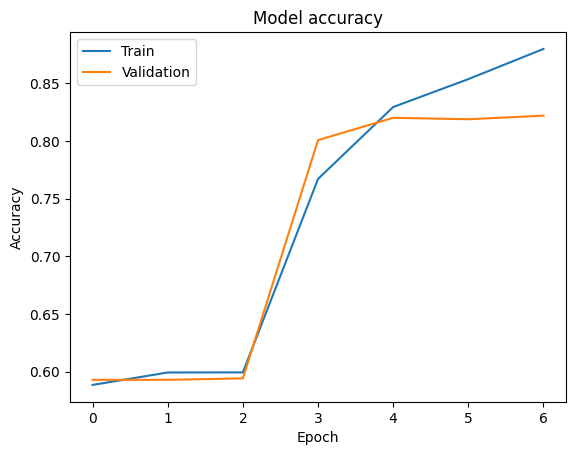

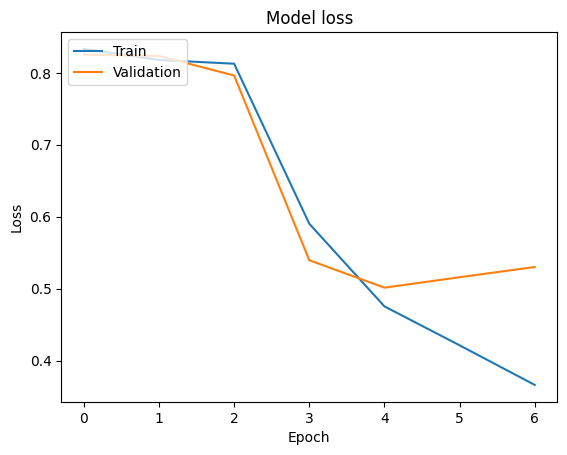

In [54]:

# Plot training & validation accuracy values
plt.plot(transformer_history.history['accuracy'])
plt.plot(transformer_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(transformer_history.history['loss'])
plt.plot(transformer_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Simple RNN
(Architecture)

In [55]:

class SRNN:
    def __init__ (self):
        self.model = Sequential()
        self.history = None
    # Model arcitecture    
    def build(self,vocab_size, embedding_dim, max_length, lstm_units=16):
        
        # Embedding layer
        self.model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
        self.model.add(Dropout(0.3))

        # Simple RNN layers
#         self.model.add(SimpleRNN(units=64, activation='relu',return_sequences = True)) 
#         self.model.add(Bidirectional(SimpleRNN(units=64, return_sequences = True)))
        self.model.add(Bidirectional(SimpleRNN(units=32)))

        self.model.add(Flatten())

        # Additional Dense layer
        self.model.add(Dense(units=64, activation='relu'))
        self.model.add(Dropout(0.3))

        # Output layer
        self.model.add(Dense(units=3, activation='softmax'))
        
        # Configure model

        optimizer = Adam(learning_rate=0.0001)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return self.model
    
    # Fit the model and return the history of learning
    def train(self, X_train, y_train, X_valid, y_valid, epochs=20, batch_size=100, early_stopping =True):
        
        # Applying early stopping to prevent overfitting 
        if(early_stopping):
            early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
            
        self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True,
                            validation_data=(X_valid,y_valid), callbacks= early_stopping)
        return self.history
   
  
   # Generate predicted labels
    def predict(self, X_test): 
        
        # Probabilities of the 3 classes       
        predicted_labels = self.model.predict(X_test)
        
        # Extracting the index of the most probable class and adjusting to a convention of [-1, 0, 1].
        predicted_labels = np.argmax(predicted_labels, axis=1) - 1
        return predicted_labels

        


(Training)

In [56]:
rnn_model = SRNN()
rnn_model.build(vocab_size, embedding_dim, max_length)
rnn_history = rnn_model.train(X_train, y_train, X_valid, y_valid,epochs = 5, early_stopping=True)


Epoch 1/5
289/289 [==============================] - 183s 622ms/step - loss: 0.8352 - accuracy: 0.6202 - val_loss: 0.7351 - val_accuracy: 0.6735
Epoch 2/5
289/289 [==============================] - 164s 567ms/step - loss: 0.6672 - accuracy: 0.7366 - val_loss: 0.5769 - val_accuracy: 0.7665
Epoch 3/5
289/289 [==============================] - 160s 555ms/step - loss: 0.5150 - accuracy: 0.8166 - val_loss: 0.4991 - val_accuracy: 0.8196
Epoch 4/5
289/289 [==============================] - 157s 542ms/step - loss: 0.4329 - accuracy: 0.8554 - val_loss: 0.4831 - val_accuracy: 0.8308
Epoch 5/5
289/289 [==============================] - 155s 536ms/step - loss: 0.3758 - accuracy: 0.8769 - val_loss: 0.4869 - val_accuracy: 0.8315


(Analysis)

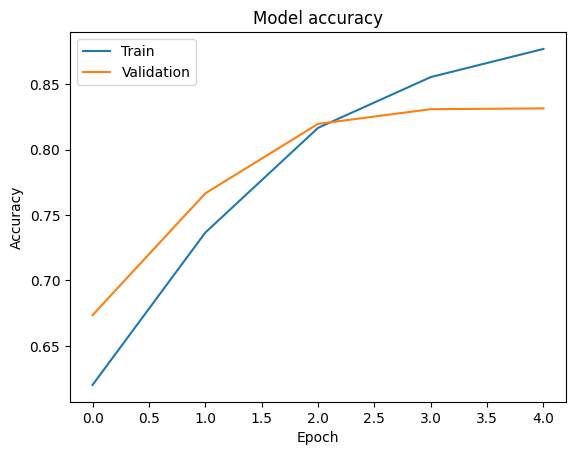

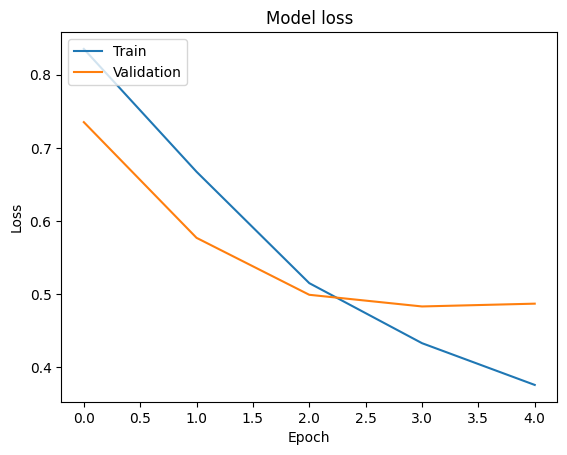

In [58]:

# Plot training & validation accuracy values
plt.plot(rnn_history.history['accuracy'])
plt.plot(rnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing
(LSTM)

In [59]:


predicted_labels = lstm_model.predict(X_test)

accuracy = np.mean(predicted_labels == y_test)

print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")

51/51 [==============================] - 1s 10ms/step
Accuracy on Test Data: 84.08%


(Transformer)

In [60]:
predicted_labels = transformer_model.predict(X_test)

accuracy = np.mean(predicted_labels == y_test)

print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")

51/51 [==============================] - 1s 10ms/step
Accuracy on Test Data: 82.52%


(RNN)


In [61]:
predicted_labels = rnn_model.predict(X_test)

accuracy = np.mean(predicted_labels == y_test)

print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")

51/51 [==============================] - 2s 44ms/step
Accuracy on Test Data: 83.46%


## Predicting
modify __model__ variable with the desired model

In [ ]:
model = lstm_model 
predicted_labels = model.predict(X_predict)
predicted_labels

## Save labels as a CSV with the following format: {ID, Rate}

ID: Review number

Rate: Predicted rating

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'ID': idx, 'Rate': predicted_labels})

# Save the DataFrame as a CSV file
df.to_csv('Predicted_Rate.csv', index=False)
df

## Save Model's weights

(LSTM)

In [30]:
weights_path = 'LSTM_Model.pkl'
with open(weights_path, 'wb') as f:
    pickle.dump(lstm_model.model.get_weights(), f)